### Importing needed libaries

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
from torch.nn import functional as F

### Download data

In [2]:
!wget --no-check-certificate 'https://www.dropbox.com/scl/fi/kkrfmiskhap3rxvh6vv8b/pb3_train.txt?rlkey=13xaop0af6c7xhhwtpzfimuqc&dl=0' -O ./data_train.txt

with open('data_train.txt', 'r', encoding='utf-8') as f:
    text = f.read()

--2024-03-01 14:26:23--  https://www.dropbox.com/scl/fi/kkrfmiskhap3rxvh6vv8b/pb3_train.txt?rlkey=13xaop0af6c7xhhwtpzfimuqc&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc86b3aa58691d2487f5485a1bc4.dl.dropboxusercontent.com/cd/0/inline/COTXWbjR8by_JZO1PaEBT898tqpmE7IA4Zvy-duJWBPAzXAZdTgRBIplTJwrApiAIptJK05Tpe0aIFHNBxd6dp4NMo__hvzqjk6khY3rFBxOtb9WH1VsxSlvzqZGKTXybSLT1-x4f9B-CxGhzgu9pIvZ/file# [following]
--2024-03-01 14:26:25--  https://uc86b3aa58691d2487f5485a1bc4.dl.dropboxusercontent.com/cd/0/inline/COTXWbjR8by_JZO1PaEBT898tqpmE7IA4Zvy-duJWBPAzXAZdTgRBIplTJwrApiAIptJK05Tpe0aIFHNBxd6dp4NMo__hvzqjk6khY3rFBxOtb9WH1VsxSlvzqZGKTXybSLT1-x4f9B-CxGhzgu9pIvZ/file
Resolving uc86b3aa58691d2487f5485a1bc4.dl.dropboxusercontent.com (uc86b3aa58691d2487f5485a1bc4.dl.dropboxusercontent.com)... 162.125.3.15

### Tokenizer

In [3]:
class Tokenizer:
    ''' Tokenizer class '''

    def __init__(self, vocab):
        ''' Initialize tokenizer '''

        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.stoi = { ch:i for i,ch in enumerate(vocab) }
        self.itos = { i:ch for i,ch in enumerate(vocab) }
        self.encode = lambda s: [self.stoi[c] for c in s]
        self.decode = lambda l: ''.join([self.itos[i] for i in l])

# Load vocabulary
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    raw = f.read()
vocab = sorted(set(raw))


# Create tokenizer
tokenizer = Tokenizer(vocab)
print('Vocab size:', tokenizer.vocab_size)

--2024-03-01 14:26:48--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2024-03-01 14:26:48 (22.2 MB/s) - ‘input.txt’ saved [1115394/1115394]

Vocab size: 65


### Hyper-parameters

In [28]:
# TODO: choose hyper-parameters
batch_size = 32 # How many samples to process at each iteration (DO NOT CHANGE)
block_size = 128  # Maximum context length (DO NOT CHANGE)
max_iters = 4000 # Maximum number of iterations
eval_interval = 500 # How often to evaluate the model
learning_rate = 1e-3  # Learning rate
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device (accelerator)
eval_iters = 200 # Number of steps to evaluate the model
n_embd = 64 # Embedding dimension (should be divisible by n_head)
n_head = 4 # Number of heads
n_layer = 16 # Number of layers
dropout = 0.0 # Dropout probability [0, 1]

### Train and test splits

In [29]:
''' Data tokenization and splits '''
# TODO: complete the code to encode the text by the tokenizer
tokenized_text = tokenizer.encode(text)
data = torch.tensor(tokenized_text, dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(text[:9])
print(train_data[:9])

First Cit
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])


### Get batch of data for training

In [30]:
def get_batch(split):
    ''' Generate a small batch of data of inputs x and targets y '''

    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    # TODO: complete the code to implement next token prediction by defining y
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Estimate loss

In [31]:
@torch.no_grad()
def estimate_loss():
    ''' Estimate loss '''

    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

### Transformer Modules

In [32]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        # TODO: Complete the code by defining the key, query and value as Linear operations without bias
        # Hint: dimensions of the linear operations must be n_embd x head_size
        self.key = nn.Linear(n_embd,head_size,bias=False)
        self.query = nn.Linear(n_embd,head_size,bias=False)
        self.value = nn.Linear(n_embd,head_size,bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        # TODO: Transform the input x by apply the key and query operations to get k and q
        k = self.key(x)
        q = self.query(x)

        # TODO: Implement the scaled self-attention mechanism by multiplying keys and queries
        # Hint: scale by multiplying by C ** -0.5 and use .transpose(-2, -1)
        A = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)

        A = A.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        # TODO: Apply softmax function to A by setting dim=-1
        # Hint: use the function F.softmax
        A = F.softmax(A,dim=-1)


        A = self.dropout(A)
        # TODO: transform the input x to get the values
        v = self.value(x)
        # TODO: Multiply values by A to obtain the output
        # Hint: the output should have the same shape as input x i.e. (B, T, C)
        out = A @ v
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        ''' n_embd: embedding dimension, n_head: the number of heads '''

        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # TODO: Implement the forward pass by applying the following operations:
        # 1) apply layer norm ln1 to x
        # 2) apply self-attention sa to the result in step 1)
        # 3) add skip connection by adding the input x to the result in step 2)
        x = x + self.sa(self.ln1(x))
        # TODO: Implement the forward pass by applying the following operations:
        # a) apply layer norm ln2 to the result in step 3)
        # b) apply feed-forward ffwd to the result in step a)
        # c) add skip connection by adding the input x to the result in step b)
        x = x + self.ffwd(self.ln2(x))
        return x

### Transformer Architecture

In [33]:
class Transformer(nn.Module):
    ''' A Transformer model '''

    def __init__(self, n_layer):
        ''' n_layer: the number of Transformer blocks '''

        super().__init__()
        self.token_embedding_table = nn.Embedding(tokenizer.vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, tokenizer.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # TODO: define tok_emb by applying token_embedding_table to the input idx
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        # TODO: add tok_emb and pos_emb to get x
        x = tok_emb + pos_emb
        # TODO: apply the blocks to get the output
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # TODO: compute the cross entropy loss
            loss = F.cross_entropy(logits,targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

### Define model

In [34]:
model = Transformer(n_layer=n_layer)

### Training loop

In [35]:
m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
val_loss = []
print(max_iters)
for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        val_loss.append(losses['val'])

    # TODO: get a batch of training samples by calling the function get_batch
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    # TODO: backpropagate on the loss
    loss.backward()
    optimizer.step()

0.813377 M parameters
4000
step 0: train loss 4.3954, val loss 4.3938
step 500: train loss 2.1424, val loss 2.2062
step 1000: train loss 1.7270, val loss 1.9031
step 1500: train loss 1.5600, val loss 1.8156
step 2000: train loss 1.4798, val loss 1.7613
step 2500: train loss 1.4203, val loss 1.7348
step 3000: train loss 1.3823, val loss 1.7129
step 3500: train loss 1.3537, val loss 1.7238
step 3999: train loss 1.3357, val loss 1.7173


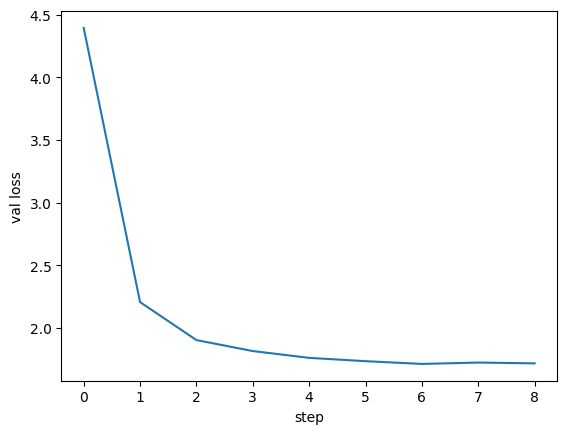

In [36]:
# plot validation loss
plt.plot(val_loss)
plt.xlabel('step')
plt.ylabel('val loss')
plt.show()

In [37]:
# Save final model checkpoint and architecture
torch.save(model, 'model.pth')